In [18]:
import os
import re
from datetime import datetime

from dateutil import parser
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
import statsmodels.stats.multitest as stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy

## preprocessing

In [19]:
df = pd.read_csv('../data/storm_results_continuous_ES.csv', sep=',')

df = pd.read_csv('/Users/estorrs/Downloads/storm_results_190605.csv', sep=',', encoding='latin')
df = df.iloc[:, :28]

print(df.shape)
df.head()

(179, 28)


,site,ISA,karst_features,sinkholes,forest_cover,developed_open_space,Watershed_area_km2,nest,time_start,time_lamber_-5hr,...,q_peak_cms,bf_peak,Area_norm_baseflow_atPeakQ,time_Bfmin,Bfmin,storm_BF_5Peak,storm_BF_95_2hr,final_storm_baseflow,Def_type,notes
0,BOHN,7.1,8,1,54.84,12.95,29.266887,NaN,10/7/2018 13:15,10/6/2018 18:51,...,1.056218,0.250752,9.050000e-09,10/7/2018 18:05,0.249851,0.633895,NaN,0.633895,1,NaN
1,BOHN,7.1,8,1,54.84,12.95,29.266887,NaN,6/25/2018 17:55,6/26/2018 6:51,...,1.144001,0.743809,2.910000e-08,6/27/2018 1:10,0.528397,0.676582,NaN,0.676582,1,kept 6/19 BF value; compound storm with antece...
2,BOHN,7.1,8,1,54.84,12.95,29.266887,NaN,8/29/2018 5:40,8/29/2018 6:51,...,1.973684,0.654410,4.410000e-08,8/29/2018 8:25,0.273620,0.628588,0.663801,0.628588,1,NaN
3,BOHN,7.1,8,1,54.84,12.95,29.266887,NaN,5/20/2018 4:55,5/21/2018 0:51,...,2.112437,0.518144,3.740000e-08,5/21/2018 1:25,0.486107,0.639337,0.687306,0.639337,1,tail of 95% BF stop dragged out
4,BOHN,7.1,8,1,54.84,12.95,29.266887,NaN,8/10/2018 12:05,8/10/2018 18:51,...,2.514536,0.626000,5.380000e-08,8/10/2018 19:25,0.624000,0.706497,0.716926,0.706497,1,NaN


In [20]:
# untransformed = pd.read_csv('../data/storm_results_continuous_ES.csv', sep=',')
untransformed = pd.read_csv('/Users/estorrs/Downloads/storm_results_190605.csv', sep=',', encoding='latin')


In [21]:

df.index = list(df['site'])

df = df.drop(labels=['site', 'notes', 'nest'], axis=1)

df = df.drop(labels=['time_lamber_-5hr', 'time_end_est1', 'time_end_5%peak', 'time_end_95_BF_2hr',
                    'time_peak', 'time_Bfmin'], axis=1)


# DCL, Sugar and GG_Weid
# df = df.drop(labels=['DCL', 'Sugar', 'GG_Weid'], axis=0)
df.head()

,ISA,karst_features,sinkholes,forest_cover,developed_open_space,Watershed_area_km2,time_start,Lambert_ppt_mm,lagtime_lambert,q_peak,5%_peak,q_peak_cms,bf_peak,Area_norm_baseflow_atPeakQ,Bfmin,storm_BF_5Peak,storm_BF_95_2hr,final_storm_baseflow,Def_type
BOHN,7.1,8,1,54.84,12.95,29.266887,10/7/2018 13:15,6.02,1399.0,37.3,1.865,1.056218,0.250752,9.050000e-09,0.249851,0.633895,NaN,0.633895,1
BOHN,7.1,8,1,54.84,12.95,29.266887,6/25/2018 17:55,5.21,999.0,40.4,2.020,1.144001,0.743809,2.910000e-08,0.528397,0.676582,NaN,0.676582,1
BOHN,7.1,8,1,54.84,12.95,29.266887,8/29/2018 5:40,4.50,299.0,69.7,3.485,1.973684,0.654410,4.410000e-08,0.273620,0.628588,0.663801,0.628588,1
BOHN,7.1,8,1,54.84,12.95,29.266887,5/20/2018 4:55,1.96,99.0,74.6,3.730,2.112437,0.518144,3.740000e-08,0.486107,0.639337,0.687306,0.639337,1
BOHN,7.1,8,1,54.84,12.95,29.266887,8/10/2018 12:05,4.98,NaN,88.8,4.440,2.514536,0.626000,5.380000e-08,0.624000,0.706497,0.716926,0.706497,1


In [22]:
def datetime_string_to_month(datetime_str):
    d = parser.parse(datetime_str)
    
    return d.month

df['date_storm'] = [datetime_string_to_month(d) for d in df['time_start']]
untransformed['date_storm'] = [datetime_string_to_month(d) for d in df['time_start']]

df = df.drop(labels=['time_start'], axis=1)



# df['time_Bfmin'] = [datetime_string_to_month(d) for d in df['time_Bfmin']]
# df['time_start'] = [datetime_string_to_month(d) for d in df['time_start']]
# df['time_lamber_-5hr'] = [datetime_string_to_month(d) for d in df['time_lamber_-5hr']]
# df['time_end_est1'] = [datetime_string_to_month(d) for d in df['time_end_est1']]
# df['time_lamber_-5hr'] = [datetime_string_to_month(d) for d in df['time_lamber_-5hr']]


df.head()

,ISA,karst_features,sinkholes,forest_cover,developed_open_space,Watershed_area_km2,Lambert_ppt_mm,lagtime_lambert,q_peak,5%_peak,q_peak_cms,bf_peak,Area_norm_baseflow_atPeakQ,Bfmin,storm_BF_5Peak,storm_BF_95_2hr,final_storm_baseflow,Def_type,date_storm
BOHN,7.1,8,1,54.84,12.95,29.266887,6.02,1399.0,37.3,1.865,1.056218,0.250752,9.050000e-09,0.249851,0.633895,NaN,0.633895,1,10
BOHN,7.1,8,1,54.84,12.95,29.266887,5.21,999.0,40.4,2.020,1.144001,0.743809,2.910000e-08,0.528397,0.676582,NaN,0.676582,1,6
BOHN,7.1,8,1,54.84,12.95,29.266887,4.50,299.0,69.7,3.485,1.973684,0.654410,4.410000e-08,0.273620,0.628588,0.663801,0.628588,1,8
BOHN,7.1,8,1,54.84,12.95,29.266887,1.96,99.0,74.6,3.730,2.112437,0.518144,3.740000e-08,0.486107,0.639337,0.687306,0.639337,1,5
BOHN,7.1,8,1,54.84,12.95,29.266887,4.98,NaN,88.8,4.440,2.514536,0.626000,5.380000e-08,0.624000,0.706497,0.716926,0.706497,1,8


In [23]:
def impute_missing_values(df):
    X = df.values
#     imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
#     imputer.fit(X)
#     X = imputer.transform(X)
    imputer = IterativeImputer(max_iter=10, random_state=0)
    X = imputer.fit_transform(X)
    
#     scaler = StandardScaler()
#     X = scaler.fit_transform(X)
#     df = pd.DataFrame(data=X, columns=df.columns)
    return pd.DataFrame(data=X, columns=df.columns, index=df.index)
   

df = impute_missing_values(df)

In [24]:
df.head()

,ISA,karst_features,sinkholes,forest_cover,developed_open_space,Watershed_area_km2,Lambert_ppt_mm,lagtime_lambert,q_peak,5%_peak,q_peak_cms,bf_peak,Area_norm_baseflow_atPeakQ,Bfmin,storm_BF_5Peak,storm_BF_95_2hr,final_storm_baseflow,Def_type,date_storm
BOHN,7.1,8.0,1.0,54.84,12.95,29.266887,6.02,1399.00000,37.3,1.865,1.056218,0.250752,9.050000e-09,0.249851,0.633895,0.648100,0.633895,1.0,10.0
BOHN,7.1,8.0,1.0,54.84,12.95,29.266887,5.21,999.00000,40.4,2.020,1.144001,0.743809,2.910000e-08,0.528397,0.676582,0.700797,0.676582,1.0,6.0
BOHN,7.1,8.0,1.0,54.84,12.95,29.266887,4.50,299.00000,69.7,3.485,1.973684,0.654410,4.410000e-08,0.273620,0.628588,0.663801,0.628588,1.0,8.0
BOHN,7.1,8.0,1.0,54.84,12.95,29.266887,1.96,99.00000,74.6,3.730,2.112437,0.518144,3.740000e-08,0.486107,0.639337,0.687306,0.639337,1.0,5.0
BOHN,7.1,8.0,1.0,54.84,12.95,29.266887,4.98,692.26086,88.8,4.440,2.514536,0.626000,5.380000e-08,0.624000,0.706497,0.716926,0.706497,1.0,8.0


In [25]:
# explanitory = ['ISA', 'karst_features', 'sinkholes', 'forest_cover', 'developed_open_space', 'Watershed_area_km2',
#               'q_peak_cfs']
# dependent = ['lagtime_lambert_minutes', 'bf_peak', 'Area_norm_baseflow_atPeakQ', 'Bfmin', 'total_storm_baseflow']

explanitory = ['ISA', 'karst_features', 'sinkholes', 'forest_cover', 'developed_open_space', 'Watershed_area_km2',
              'q_peak', 'q_peak_cms']
dependent = ['lagtime_lambert', 'bf_peak', 'Area_norm_baseflow_atPeakQ', 'Bfmin',
             'storm_BF_5Peak', 'storm_BF_95_2hr', 'final_storm_baseflow',
            ]

In [26]:
df.columns

Index(['ISA', 'karst_features', 'sinkholes', 'forest_cover',
       'developed_open_space', 'Watershed_area_km2', 'Lambert_ppt_mm',
       'lagtime_lambert', 'q_peak', '5%_peak', 'q_peak_cms', 'bf_peak',
       'Area_norm_baseflow_atPeakQ', 'Bfmin', 'storm_BF_5Peak',
       'storm_BF_95_2hr', 'final_storm_baseflow', 'Def_type', 'date_storm'],
      dtype='object')

In [27]:
import statsmodels.stats.multitest as stats

In [28]:
df_mini = df[dependent]
df_mini.head()

,lagtime_lambert,bf_peak,Area_norm_baseflow_atPeakQ,Bfmin,storm_BF_5Peak,storm_BF_95_2hr,final_storm_baseflow
BOHN,1399.00000,0.250752,9.050000e-09,0.249851,0.633895,0.648100,0.633895
BOHN,999.00000,0.743809,2.910000e-08,0.528397,0.676582,0.700797,0.676582
BOHN,299.00000,0.654410,4.410000e-08,0.273620,0.628588,0.663801,0.628588
BOHN,99.00000,0.518144,3.740000e-08,0.486107,0.639337,0.687306,0.639337
BOHN,692.26086,0.626000,5.380000e-08,0.624000,0.706497,0.716926,0.706497


In [29]:
es, ds, corrs, ps = [], [], [], []
for e in explanitory:
    ls = list(df[e])
    for c in df_mini.columns:
        xs = list(df_mini[c])
        
        corr, p_value = scipy.stats.pearsonr(ls, xs)
        if p_value < .05:
            es.append(e)
            ds.append(c)
            corrs.append(corr)
            ps.append(p_value)

            plotting_df = pd.DataFrame.from_dict({'explanitory': es, 'dependent': ds, 'correlation': corrs, 'p_value': ps})
plotting_df

,explanitory,dependent,correlation,p_value
0,ISA,Bfmin,-0.158621,3.394042e-02
1,ISA,storm_BF_5Peak,-0.242615,1.066921e-03
2,ISA,storm_BF_95_2hr,-0.284977,1.104029e-04
3,ISA,final_storm_baseflow,-0.252713,6.426397e-04
4,karst_features,Bfmin,0.166695,2.573207e-02
5,sinkholes,Bfmin,0.161240,3.106377e-02
6,forest_cover,storm_BF_95_2hr,0.163347,2.890189e-02
7,forest_cover,final_storm_baseflow,0.149062,4.642790e-02
8,Watershed_area_km2,Area_norm_baseflow_atPeakQ,-0.158182,3.444409e-02
9,Watershed_area_km2,Bfmin,0.334021,4.888397e-06


In [30]:
es, ds, corrs, ps = [], [], [], []
for e in explanitory:
    ls = list(df[e])
    for c in df_mini.columns:
        xs = list(df_mini[c])
        
        corr, p_value = scipy.stats.spearmanr(ls, xs)
        if p_value < .05:
            es.append(e)
            ds.append(c)
            corrs.append(corr)
            ps.append(p_value)

            plotting_df = pd.DataFrame.from_dict({'explanitory': es, 'dependent': ds, 'correlation': corrs, 'p_value': ps})
plotting_df

,explanitory,dependent,correlation,p_value
0,ISA,lagtime_lambert,-0.150259,4.467928e-02
1,ISA,Area_norm_baseflow_atPeakQ,0.183535,1.392260e-02
2,ISA,storm_BF_5Peak,-0.250071,7.352577e-04
3,ISA,storm_BF_95_2hr,-0.302928,3.759600e-05
4,ISA,final_storm_baseflow,-0.253735,6.097801e-04
5,karst_features,Area_norm_baseflow_atPeakQ,-0.260058,4.386711e-04
6,karst_features,Bfmin,0.334319,4.788360e-06
7,karst_features,storm_BF_5Peak,0.235862,1.480481e-03
8,karst_features,storm_BF_95_2hr,0.216440,3.613663e-03
9,karst_features,final_storm_baseflow,0.231161,1.849882e-03


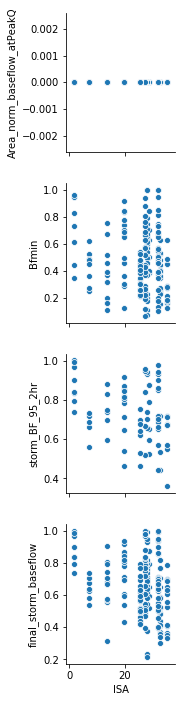

In [31]:
axs = sns.pairplot(untransformed, x_vars=['ISA'],
                   y_vars=['Area_norm_baseflow_atPeakQ', 'Bfmin', 'storm_BF_95_2hr', 'final_storm_baseflow'])

/Users/estorrs/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/estorrs/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


44 72
rural suburban Ttest_indResult(statistic=1.733579904225913, pvalue=0.0856962836793548)
44 63
rural urban Ttest_indResult(statistic=3.5868442508236438, pvalue=0.0005098860953181018)
72 44
suburban rural Ttest_indResult(statistic=-1.733579904225913, pvalue=0.0856962836793548)
72 63
suburban urban Ttest_indResult(statistic=2.031470161437005, pvalue=0.04419940798065578)
63 44
urban rural Ttest_indResult(statistic=-3.5868442508236438, pvalue=0.0005098860953181018)
63 72
urban suburban Ttest_indResult(statistic=-2.031470161437005, pvalue=0.04419940798065578)


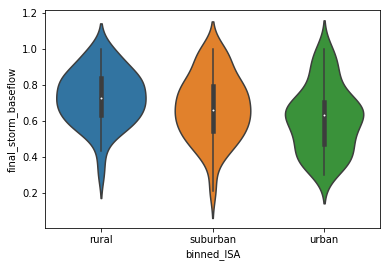

In [32]:
plotting_df = untransformed[['ISA', 'final_storm_baseflow']]

def bin_total_storm_baseflow(n):
    if n > .8:
        return 'high'
    elif n > .5:
        return 'medium'
    elif n > 0:
        return 'low'
    
    return np.nan

def bin_ISA(n):
    if n > 30:
        return 'urban'
    elif n > 20:
        return 'suburban'
    elif n > 0:
        return 'rural'
    
    return np.nan

plotting_df['binned_total_storm_baseflow'] = [bin_total_storm_baseflow(n)
                                              for n in plotting_df['final_storm_baseflow']]
plotting_df['binned_ISA'] = [bin_ISA(n)
                            for n in plotting_df['ISA']]
ax = sns.violinplot(x="binned_ISA", y="final_storm_baseflow", data=plotting_df,
                   order=['rural', 'suburban', 'urban'])

for x in ['rural', 'suburban', 'urban']:
    for y in ['rural', 'suburban', 'urban']:
        if x != y:
            ls = plotting_df[plotting_df['binned_ISA']==x]['final_storm_baseflow']
            xs = plotting_df[plotting_df['binned_ISA']==y]['final_storm_baseflow']
            print(len(ls), len(xs))
            print(x, y, scipy.stats.ttest_ind(ls, xs))

In [33]:
# axs = sns.pairplot(untransformed, x_vars=['forest_cover'],
#                    y_vars=['lagtime_lambert_minutes', 'Bfmin', 'total_storm_baseflow'])

In [34]:
# axs = sns.pairplot(untransformed, x_vars=['sinkholes'],
#                    y_vars=['Area_norm_baseflow_atPeakQ'])

# plt.ylim(-.000001, .000001)

In [35]:
# axs = sns.pairplot(untransformed, x_vars=['q_peak_cfs'], 
#                    y_vars=['lagtime_lambert_minutes', 'bf_peak', 'Area_norm_baseflow_atPeakQ',
#                            'Bfmin', 'total_storm_baseflow'])

In [36]:
# plotting_df.head()

/Users/estorrs/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/estorrs/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


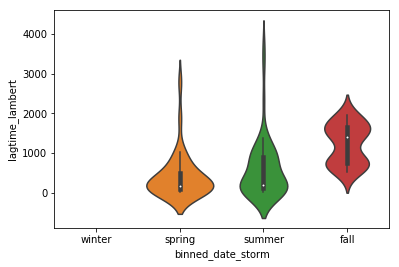

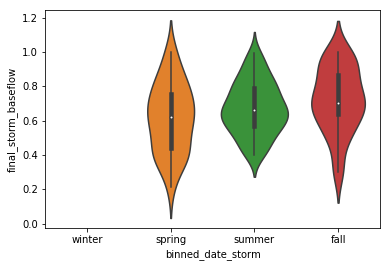

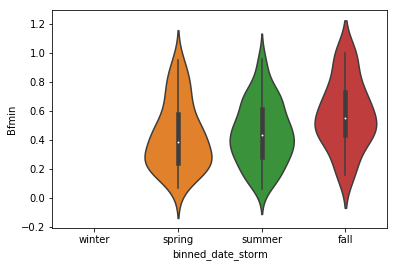

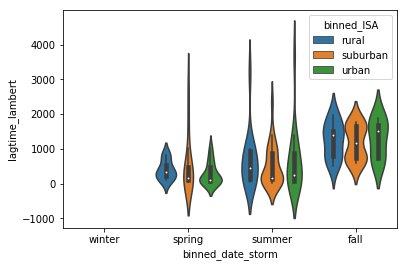

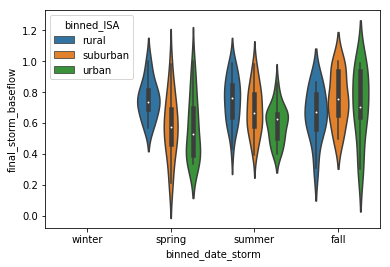

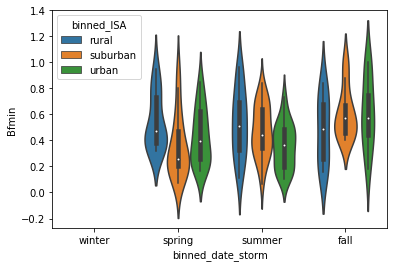

In [37]:
plotting_df = untransformed[['date_storm', 'ISA'] + dependent]
# plotting_df['date_storm'] = [datetime_string_to_month(d) for d in plotting_df['date_storm']]
plotting_df['binned_ISA'] = [bin_ISA(n)
                            for n in plotting_df['ISA']]

y_variable = 'lagtime_lambert'
y_vars = ['lagtime_lambert', 'final_storm_baseflow', 'Bfmin']
def bin_date_storm(n):
    if n in [12.0, 1.0, 2.0]:
        return 'winter'
    elif n in [3.0, 4.0, 5.0]:
        return 'spring'
    elif n in [6.0, 7.0, 8.0]:
        return 'summer'
    elif n in [9.0, 10.0, 11.0]:
        return 'fall'
    
    return np.nan

plotting_df['binned_date_storm'] = [bin_date_storm(n)
                            for n in plotting_df['date_storm']]

for y_variable in y_vars:
    ax = sns.violinplot(x="binned_date_storm", y=y_variable, data=plotting_df,
                       order=['winter', 'spring', 'summer', 'fall'])
    plt.show()
    
for y_variable in y_vars:
    ax = sns.violinplot(x="binned_date_storm", y=y_variable, data=plotting_df, hue='binned_ISA',
                       order=['winter', 'spring', 'summer', 'fall'])
    plt.show()

# for x in ['winter', 'spring', 'summer', 'fall']:
#     for y in ['winter', 'spring', 'summer', 'fall']:
#         if x != y:
#             ls = plotting_df[plotting_df['binned_date_storm']==x][y_variable]
#             xs = plotting_df[plotting_df['binned_date_storm']==y][y_variable]
            
#             print(len(ls), len(xs))
#             print(x, y, scipy.stats.ttest_ind(ls, xs))

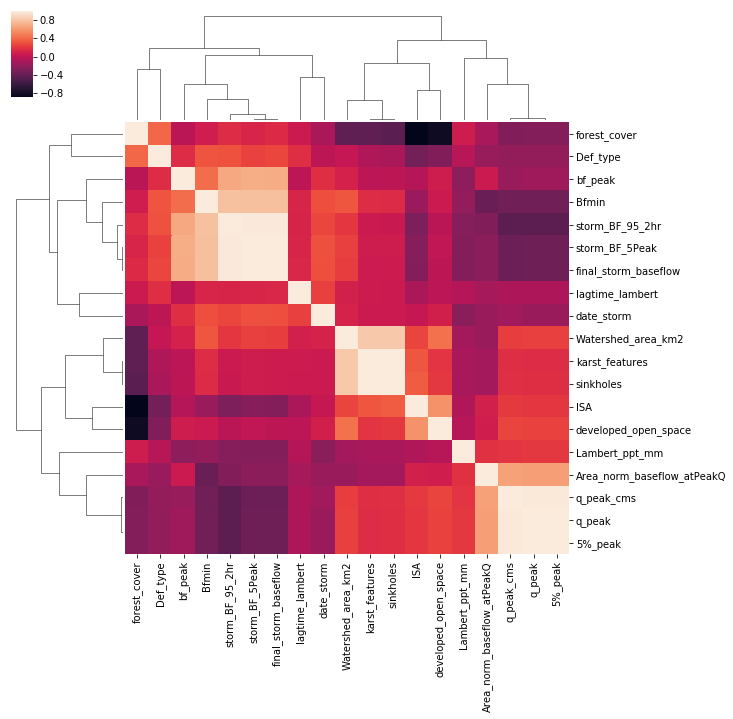

In [97]:
axs = sns.clustermap(df.corr())

In [126]:
x = 'storm_BF_5Peak'
y = 'storm_BF_95_2hr'

In [127]:
xs, ys = [], []
for x, y in zip(untransformed['storm_BF_5Peak'], untransformed['storm_BF_95_2hr']):
    if not pd.isna(x) and not pd.isna(y):
        xs.append(x)
        ys.append(y)

In [128]:
len(xs), len(ys)

(62, 62)

In [129]:
scipy.stats.ttest_ind(xs, ys)

Ttest_indResult(statistic=-0.5137007877421825, pvalue=0.6083903277957414)

In [116]:
a = xs[15]

In [117]:
a.is_integer()

False

In [118]:
type(a)

float

In [119]:
a

nan

In [120]:
np.nan

nan